In [30]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import WCSAxes

from lvmagp.images import Image

In [31]:
# 2 choices

# 1. with simulator on nicelab, user lvm
#   RMQ_HOST=$(minikube ip) ipython3
#   paste the code

# 2. local with image eg from nicelab:  /data/lvm/sci/agcam/east/20220927/lvm.sci.agcam.east_00003730.fits
#    python > 3.8
#    pip3 install sdss-lvmagp astrometry
#    ipython3

from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

# Load images

In [32]:
#Matar
filename_east = '/data/lvm/sci/agcam/east/20221102/lvm.sci.agcam.east_00000243.fits'
filename_west = '/data/lvm/sci/agcam/west/20221102/lvm.sci.agcam.west_00000243.fits'
filename_center = '/data/lvm/sci/agcam/center/20221102/lvm.sci.agcam.center_00000226.fits'

#Pleijades:
#filename_east= "/data/lvm/sci/agcam/east/20221026/lvm.sci.agcam.east_00001112.fits"
#filename_west = "/data/lvm/sci/agcam/west/20221026/lvm.sci.agcam.west_00001112.fits"
#filename_center = "/data/lvm/sci/agcam/center/20221026/lvm.sci.agcam.center_00000731.fits"

In [33]:
east = Image.from_file(filename_east)
data_east = east.data
    
west = Image.from_file(filename_west)
data_west = west.data
    
center = Image.from_file(filename_center)
data_center = center.data

data_center_binned = (data_center[::2,::2].astype(float)+data_center[1::2,::2].astype(float)+data_center[::2,1::2].astype(float)+data_center[1::2,1::2].astype(float))/4

images = [east, center, west]

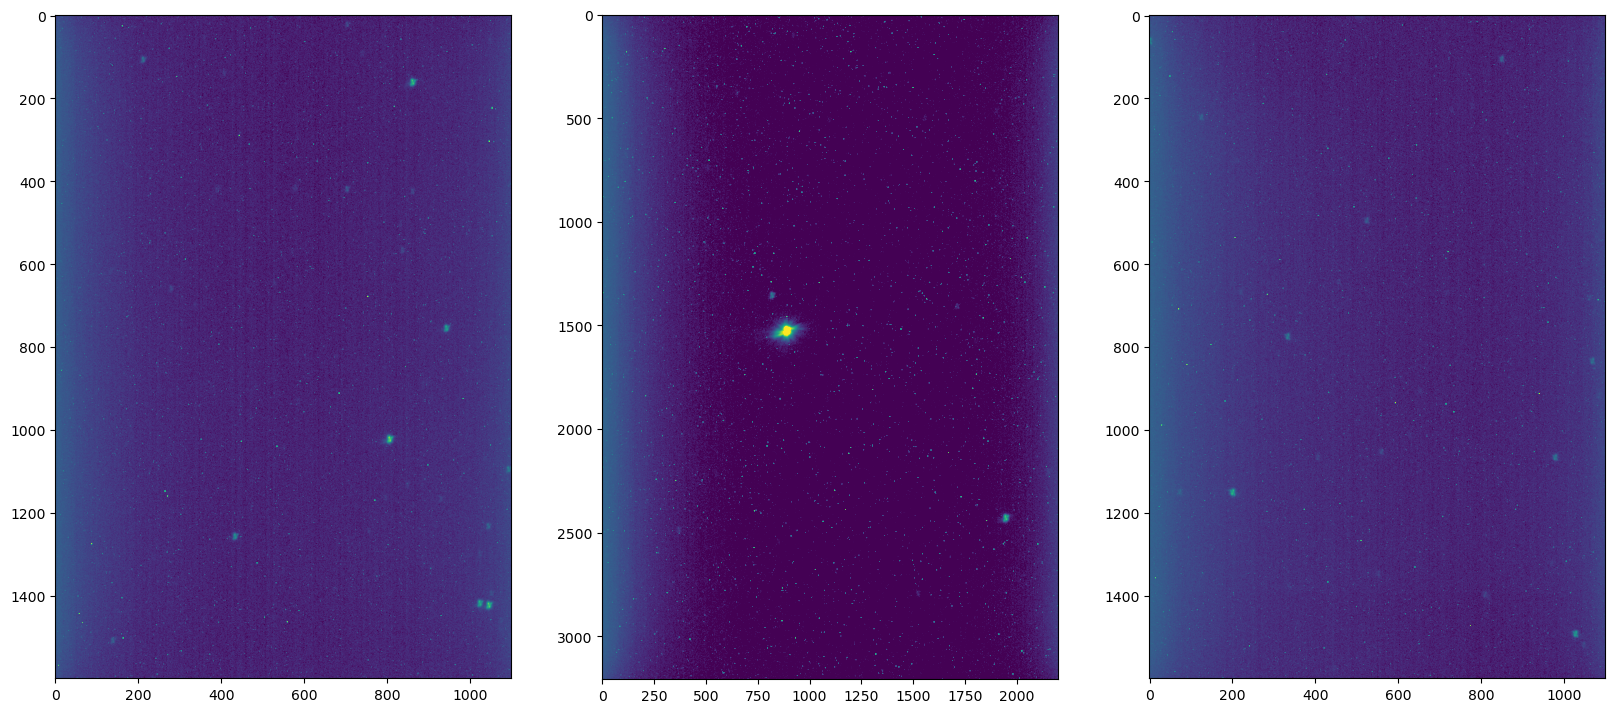

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(20,10),ncols=3)

ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=10000))
ax2.imshow(data_center.T,norm=LogNorm(vmin=50, vmax=10000))
ax3.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=10000))

In [35]:
data_center_binned.shape

(1100, 1604)

In [36]:
data_east.shape

(1100, 1600)

In [37]:
image_list = [data_east.astype(float),data_west.astype(float),data_center_binned.astype(float)]

# Correct fits header

In [ ]:
import astropy.coordinates
import astropy.time
import astropy.units as u

from lvmtipo.site import Site
from lvmtipo.siderostat import Siderostat
from lvmtipo.fiber import Fiber
from lvmtipo.target import Target
from lvmtipo.ambient import Ambient
from lvmtipo.kmirror import Kmirror

from astropy.utils import iers
iers.conf.auto_download = False

site = Site(name = "MPIA")

azang = 180.0
medSign = -1

sid = Siderostat(azang=azang, medSign=medSign)
ambi = Ambient()

homeOffset = 135
homeIsWest = False

kmirror = Kmirror(home_is_west=homeIsWest, home_offset=homeOffset)

hdu = images[0].header
print(hdu)
target = Target(astropy.coordinates.SkyCoord(ra=hdu['RA'], dec=hdu['DEC'], unit=(u.deg, u.deg)))
print(f"{hdu['RA']=} {hdu['DEC']=} {hdu['KMIRSTEP']=}  {hdu['KMIRDROT']=}   {hdu['DATE-OBS']=}")

touple_list = []
for img in images:
  touple_list.append((img.data, sid.to_wcs(site, target, None, ambi, img.header['KMIRSTEP'], 
                                            img.header['CAMNAME'], False, False, kmirror, pixsize=img.header['PIXSIZE'],
                                            bin=4,wd=img.header['NAXIS1'],hd=img.header['NAXIS2'])))

touple_list


# Run DAOphot and Astrometry

In [38]:
import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

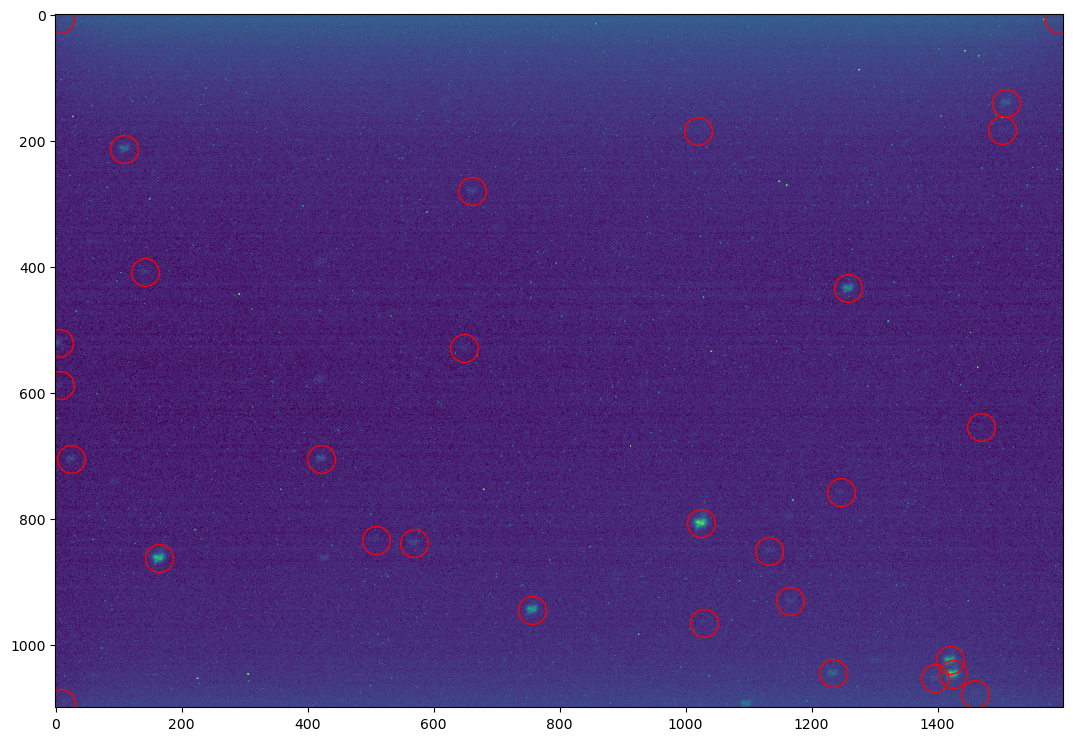

solution.best_match().center_ra_deg=340.2060430733236
solution.best_match().center_dec_deg=30.224703217983233
solution.best_match().scale_arcsec_per_pixel=1.0104541952646102
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 340.3305063955031  30.16453198709564  
CRPIX : 1008.168585986416  935.7134962103992  
CD1_1 CD1_2  : -3.7358443253065e-06  0.000280656857957186  
CD2_1 CD2_2  : -0.00028065685795718  -3.7358443253065e-06  
NAXIS : 0  0


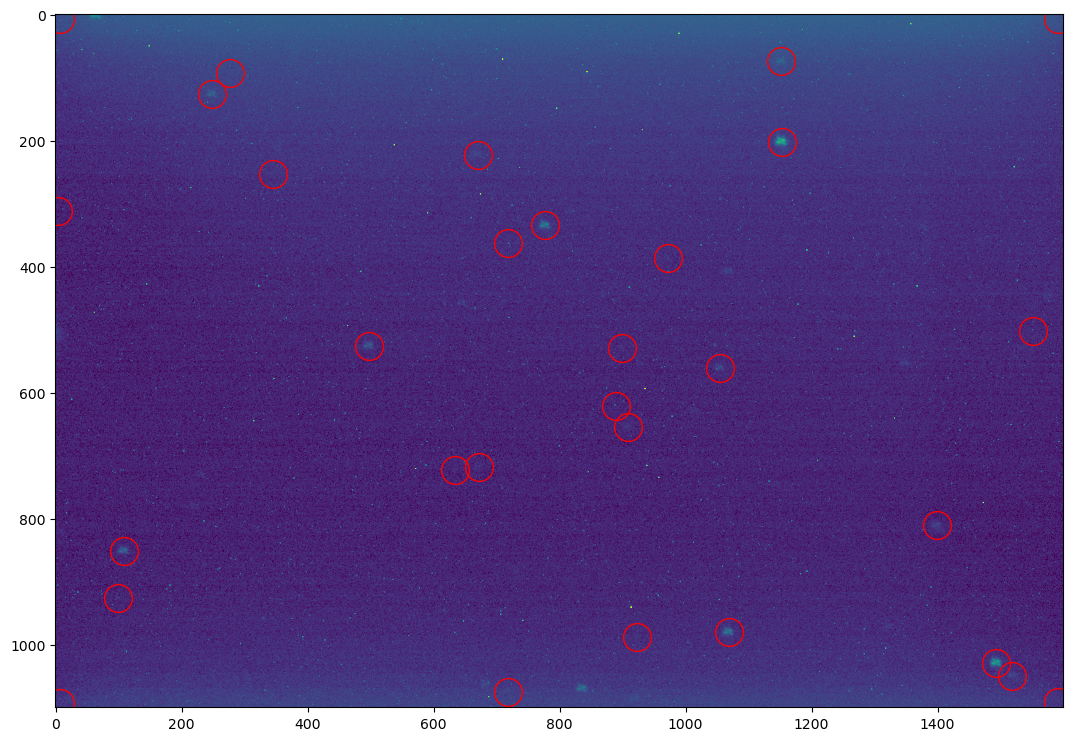

solution.best_match().center_ra_deg=341.3725047027627
solution.best_match().center_dec_deg=30.212442700152014
solution.best_match().scale_arcsec_per_pixel=1.0094936634124116
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 341.3913456244564  30.15181701618637  
CRPIX : 1012.933671631973  487.5941269055281  
CD1_1 CD1_2  : -5.0207469206108e-06  -0.00028036995539767  
CD2_1 CD2_2  : -0.00028036995539767  5.02074692061071e-06  
NAXIS : 0  0


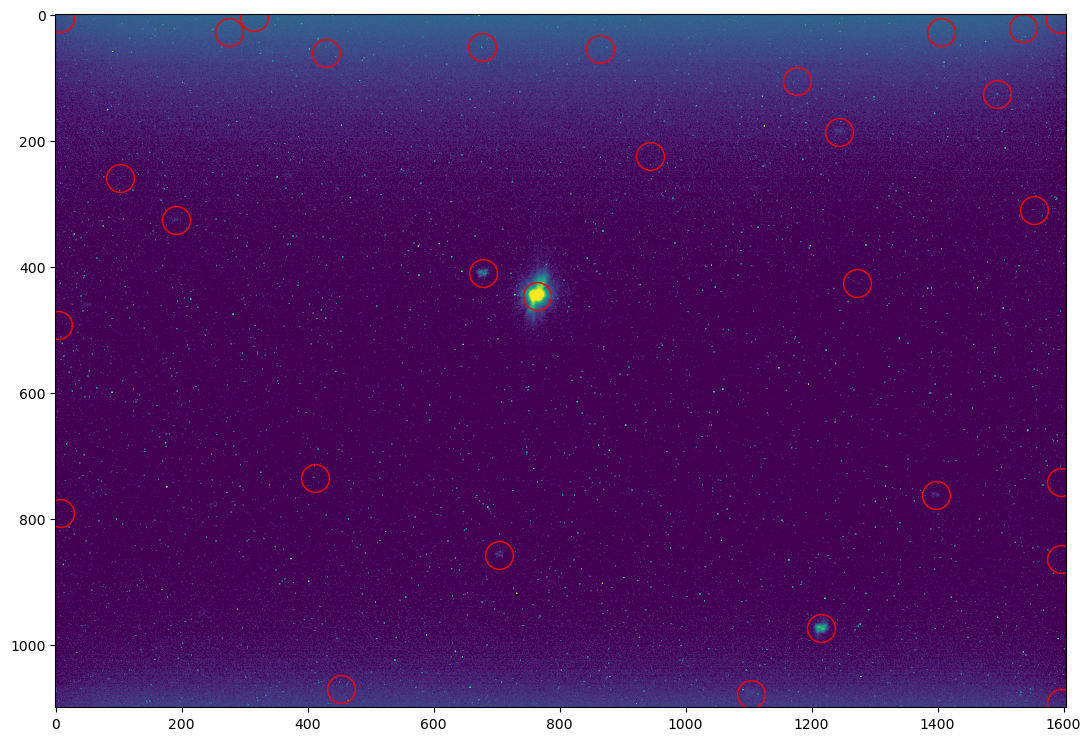

solution.best_match().center_ra_deg=340.7835998099344
solution.best_match().center_dec_deg=30.21066650530528
solution.best_match().scale_arcsec_per_pixel=1.0097389068465978
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 340.8236171550067  30.19889663501059  
CRPIX : 840.3955123746473  672.2003522500754  
CD1_1 CD1_2  : -3.793755257399e-06  0.000280457371732854  
CD2_1 CD2_2  : -0.00028045737173285  -3.7937552573991e-06  
NAXIS : 0  0


In [39]:
wcs_results = []
touple_list = []

for image_orig in image_list:
    image = median_filter(image_orig,size=2)#gaussian_filter(image_orig,sigma=5)
    bkg_sigma = mad_std(image)  
    #image_orig[image_orig>60000] = float("nan")
    daofind = DAOStarFinder(fwhm=15, threshold=4 * bkg_sigma)
    sources = daofind(image)  

    sources.sort("flux")
    sources.reverse()
    sources = sources[:30]

    for col in sources.colnames:  

        sources[col].info.format = '%.8g'  # for consistent table output

    #print(sources)  
    fig,ax1 = plt.subplots(figsize=(16,9))

    ax1.imshow(image_orig,norm=LogNorm(vmin=50, vmax=10000))
    ax1.plot(sources["xcentroid"],sources["ycentroid"],"o",markerfacecolor="none",markeredgecolor="r",ms=20)
    plt.show()

    logodds_callback = astrometry.Action.STOP

    solution = solver.solve(
    stars_xs=sources['xcentroid'],
    stars_ys=sources['ycentroid'],
    size_hint=astrometry.SizeHint(
        lower_arcsec_per_pixel=0.9,#arcsec_per_pixel-0.1,
        upper_arcsec_per_pixel=1.1,#arcsec_per_pixel+0.1,
    ),
    position_hint=None,
    #position_hint=astrometry.PositionHint(
    #    ra_deg=57.4,
    #    dec_deg=24.15,
    #    radius_deg=5,
    #),
    solution_parameters = astrometry.SolutionParameters(
        solve_id=None,
        tune_up_logodds_threshold=None,#14.0, # None disables tune-up (SIP distortion)
        output_logodds_threshold=21.0,
        logodds_callback=lambda logodds_list: logodds_callback
        )
    )
    #log.debug("Solve done")

    if solution.has_match():
        print(f"{solution.best_match().center_ra_deg=}")
        print(f"{solution.best_match().center_dec_deg=}")
        print(f"{solution.best_match().scale_arcsec_per_pixel=}")
        wcs = astropy.wcs.WCS(solution.best_match().wcs_fields)
        wcs_results.append(wcs)
        touple_list.append((image_orig,wcs))
        pixels = wcs.all_world2pix(
            [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
            0,
        )
        print(f"{wcs}")
    else:
        print("No Match!")

In [40]:
touple_list

[(array([[144., 176., 176., ..., 224., 176., 160.],
         [176., 128., 160., ..., 192., 208., 192.],
         [144., 160., 160., ..., 144., 176., 160.],
         ...,
         [ 64.,  96., 112., ..., 144.,  96., 160.],
         [112., 144., 112., ..., 112., 112., 128.],
         [ 96.,  96., 128., ...,  80., 112., 144.]]),
  WCS Keywords
  
  Number of WCS axes: 2
  CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
  CRVAL : 340.3305063955031  30.16453198709564  
  CRPIX : 1008.168585986416  935.7134962103992  
  CD1_1 CD1_2  : -3.7358443253065e-06  0.000280656857957186  
  CD2_1 CD2_2  : -0.00028065685795718  -3.7358443253065e-06  
  NAXIS : 0  0),
 (array([[144., 160., 192., ..., 192., 192., 176.],
         [160., 192., 240., ..., 208., 160., 192.],
         [176., 128., 160., ..., 208., 176., 208.],
         ...,
         [ 96.,  48., 144., ...,  16.,  96., 112.],
         [128.,  80.,  80., ..., 128.,  96.,  64.],
         [176., 128., 128., ..., 128.,  80., 112.]]),
  WCS Keywords
  
  

# Reproject images'

In [41]:
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out= reproject.mosaicking.find_optimal_celestial_wcs(touple_list)

reprojected_arrays = []
footprints = []
for index,touple in enumerate(touple_list):
    print(index)
    

    reprojected_array,current_footprint = reproject.reproject_interp(touple, wcs_out,shape_out=shape_out)
    reprojected_arrays.append(reprojected_array)
    footprints.append(current_footprint)

0
1
2


In [42]:
stack = np.array(reprojected_arrays)
stack_combined = np.nanmedian(stack,axis=0)
footprints_sum = np.sum(np.array(footprints),axis=0)

[WARNING]: All-NaN slice encountered (RuntimeWarning)
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Text(0.5, 1.0, 'Reprojected Guide Image')

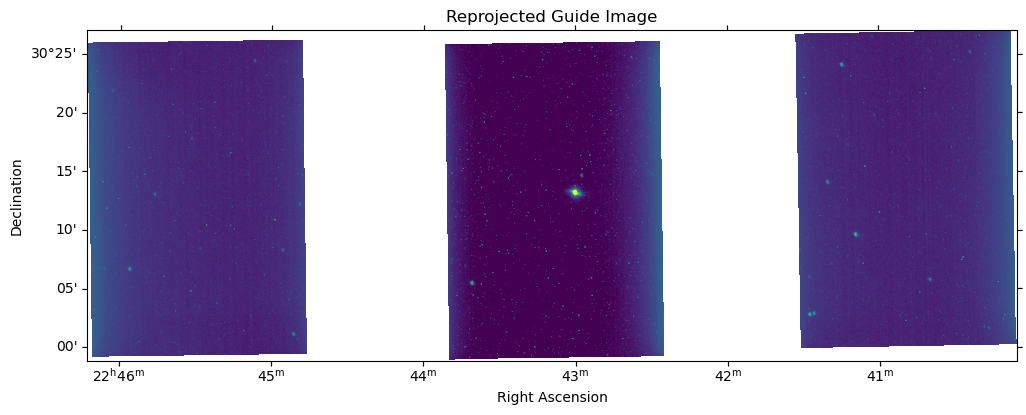

In [43]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(projection=wcs_out)
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
#ax1.plot(gaia_pixel_repro[0],gaia_pixel_repro[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected Guide Image')

# Load and show Gaia stars 

In [44]:
import astropy.units as u
from astroquery.gaia import Gaia

In [45]:
#my_wcs = wcs_out
c_icrs = wcs_out.pixel_to_world(shape_out[1]//2,shape_out[0]//2)
radius = u.Quantity(0.8, u.deg)
remote_maglim=12
#j = Gaia.cone_search_async(coordinate=c_icrs, radius)
gaia_query = "SELECT source_id, ra,dec,phot_g_mean_mag FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag <= "+str(remote_maglim)+" AND 1=CONTAINS(POINT('ICRS',ra,dec), CIRCLE('ICRS',"+str(c_icrs.ra.deg)+","+str(c_icrs.dec.deg)+", "+str(radius.value)+"))"
print("Gaia query: ",gaia_query)
j = Gaia.launch_job_async(gaia_query)
cat = j.get_results()
#print("Gaia query: ",gaia_query)
print(f'{len(cat)} stars found within {radius}')


Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
#gaia_pixel_orig = wcs.world_to_pixel(Gaiastars)
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
        
gaia_selection = (0 < gaia_pixel[0]) & (gaia_pixel[0] < shape_out[1]) & (0 < gaia_pixel[1]) & (gaia_pixel[1] < shape_out[0])
cat = cat[gaia_selection]
Gaiastars = SkyCoord(cat["ra"],cat["dec"],unit="deg")
gaia_pixel = wcs_out.world_to_pixel(Gaiastars)
print("{} of these are actually in the FOV".format(len(cat)))

Gaia query:  SELECT source_id, ra,dec,phot_g_mean_mag FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag <= 12 AND 1=CONTAINS(POINT('ICRS',ra,dec), CIRCLE('ICRS',340.788423825094,30.218064435801878, 0.8))


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
147 stars found within 0.8 deg
41 of these are actually in the FOV


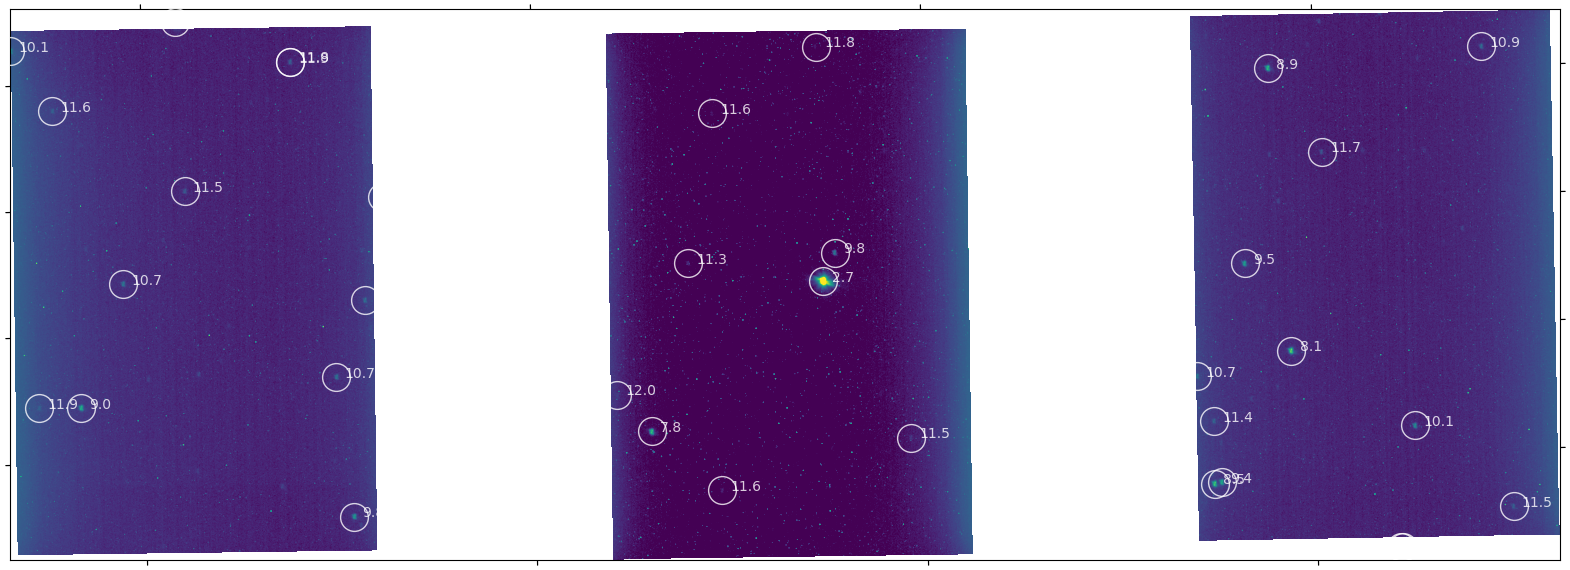

In [46]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(projection=wcs_results[0])
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
ax1.plot(gaia_pixel[0],gaia_pixel[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
#ax1.coords['ra'].set_axislabel('Right Ascension')
#ax1.coords['dec'].set_axislabel('Declination')
#ax1.set_title('2MASS K-band')

for index,entry in enumerate(cat):
    ax1.text(gaia_pixel[0][index]+25,gaia_pixel[1][index],"{:.1f}".format(entry["phot_g_mean_mag"]),color="w",alpha=0.8)
    
#ax1.set_xlim(0,1600)
#ax1.set_ylim(0,1100)